### Index
#### 1. Data Quality Check
#### 2. Feature inspection and filtering
#### 3. Feature importance ranking via learning models

### 0. Import Library and Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from sklearn.feature_selection import mutual_info_classif

In [2]:
train = pd.read_csv('./datasets/porto-seguro-safe-driver-prediction/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# Shape
rows = train.shape[0]
cols = train.shape[1]

print('The Train set contains {0} rows and {1} columns'.format(rows, cols))

The Train set contains 595212 rows and 59 columns


### 1. Data Quality Checks

In [4]:
# use any() twice to check across all columns
train.isnull().any().any()

False

In [5]:
train_copy = train.copy()
train_copy = train_copy.replace(-1, np.NaN)

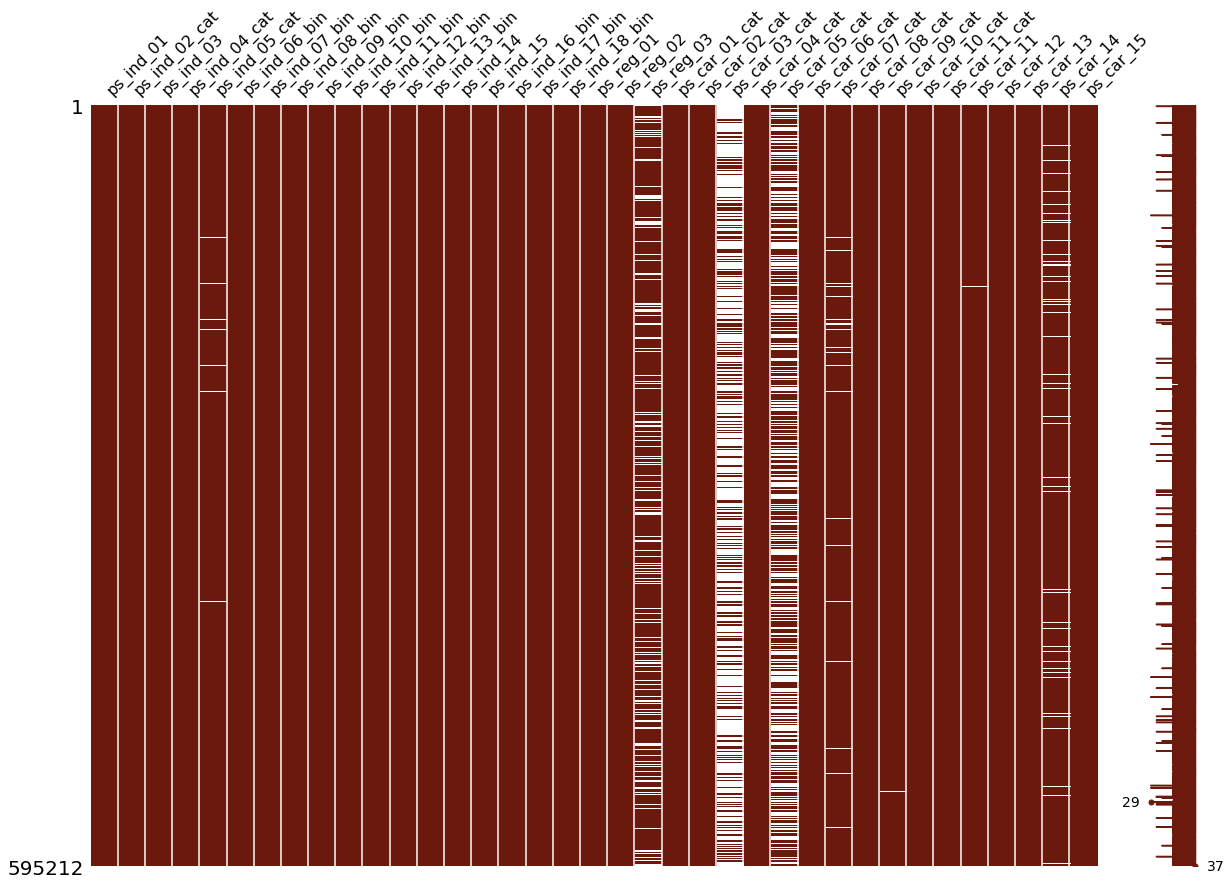

In [6]:
import missingno as msno

msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

#### Null Value가 존재하는 컬럼
#### [ps_ind_05_cat, ps_reg_03, ps_car_03_cat, ps_car_05_cat, ps_car_07_cat, ps_car_09_cat, ps_car_14 ]

In [7]:
#### Target Var Inspection

set1 = go.Bar(x=train['target'].value_counts().index.values,
             y=train['target'].value_counts().values,
             text = "Distribution of target variable")

layout = go.Layout(title='Target Variable distribution')

data = [set1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [9]:
# Datatype check
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [10]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

#### Correlation plots

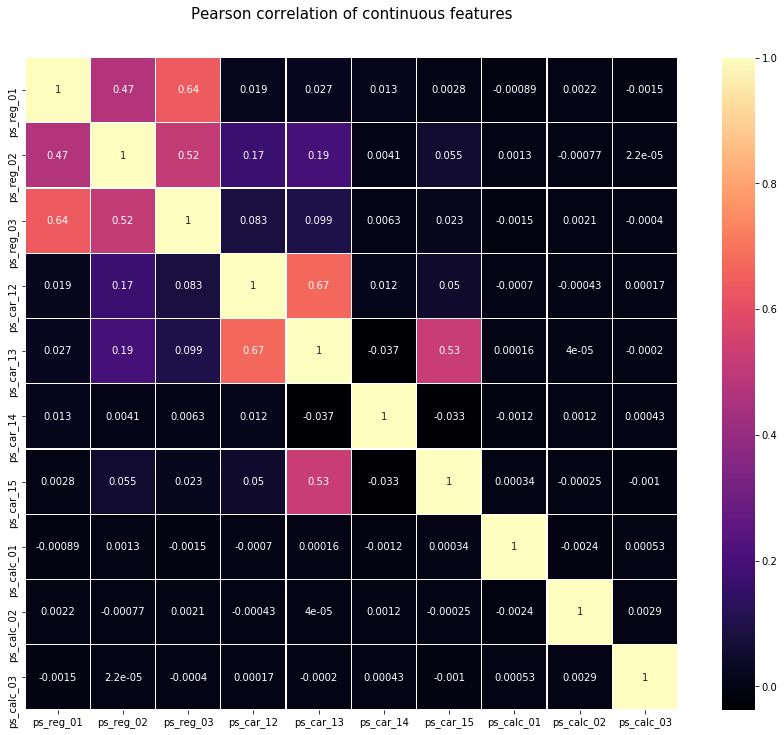

In [11]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidth=0.1, vmax=1.0, square=True,
           cmap=colormap, linecolor='white', annot=True)

In [12]:
# positive linear correlation features
# ps_reg_01, ps_reg_03
# ps_reg_02, ps_reg_03
# ps_car_12, ps_car_13
# ps_car_13, ps_car_15

In [19]:
# correlation integer figure

set2 = go.Heatmap(z=train_int.corr().values,
                 x = train_int.columns.values,
                 y = train_int.columns.values,
                 colorscale='Viridis',
                 reversescale=False,
                 #text=True,
                 opacity=1.0)

layout = go.Layout(title='Pearson Correlation of Interger type features',
                  xaxis=dict(ticks='', nticks=36),
                  yaxis=dict(ticks=''),
                  width=800, height=700)

data=[set2]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


In [20]:
#### Negative correlater features
# ps_ind_06_bin, ps_ind_07_bin, ps_ind_09_bin, ps_ind_

#### Mutual Information Plots

In [21]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


#### Binary Features Inspection

In [22]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list=[]

for col in bin_col:
    zero_list.append((train[col] ==0).sum())
    one_list.append((train[col] ==1).sum())

In [23]:
trace1 = go.Bar(\
               x=bin_col,
               y=zero_list,
               name='Zero Count')
trace2 = go.Bar(\
               x=bin_col,
               y=one_list,
               name='One Count')

data = [trace1, trace2]

layout = go.Layout(\
                  barmode='stack',
                  title='Count of 1 and 0 binary variables')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [25]:
# ps_ind_10_bin, ps_ind_11_bin, ps_bin_12_bin, ps_ind_13_bin which are completly 
# dominated by zeros

#### Feature importance via Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4,
                           max_features=0.2, n_jobs=-1, random_state=0)

rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print('-------Training Done-----------')

-------Training Done-----------


In [27]:
# Scatter Plot of feauture importance
trace = go.Scatter(\
                  x=features,
                  y=rf.feature_importances_,
                  mode='markers',
                  marker=dict(sizemode='diameter',
                             sizeref=1,
                             size=13,
                             color=rf.feature_importances_,
                             colorscale='Portland',
                             showscale=True),
                   text=features
                  )
data =[trace]

layout=go.Layout(title='Random Forest Feature Importance',
                autosize=True,
                hovermode='closest',
                xaxis=dict(ticklen=5,
                          showgrid=False,
                          zeroline=False,
                          showline=False
                          ),
                
                yaxis=dict(title='Feature Importance',
                          showgrid=False,
                          zeroline=False,
                          ticklen=5,
                          gridwidth=2),
                showlegend=False
                )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [32]:
# Feature Importance Bar Chart
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

#### Feature importance via Gradient Boosting Model

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3,
                               min_samples_leaf=4, max_features=0.2,
                               random_state=0)
gb.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print('---------Training Done---------')

---------Training Done---------


In [ ]:
# Scatter Plot of Feature Importance
trace = go.Scatter(\
                  y = gb.feature_importances_,
                  x = features,
                  mode='markers',
                  marker=dict(sizemode='diameter',
                             sizeref=1,
                             size=13,
                             color = gb.feature_importances_,
                             colorscale='Portland',
                             showscale=True),
                  text=features
                  )
data=[trace]

layout=go.Layout(autosize=True,
                title='Gradient Boosting Machine Feauture Impotance',
                hovermode='closest',
                xaxis=dict(ticklen=5,
                          showgrid=False,
                          zeroline=False,
                          showline=False),
                yaxis=dict(title='Feature Importance',
                          showgrid=False,
                          zeroline=False,
                          ticklen=5,
                          gridwidth=2),
                showlegend=False
                )
fig = go.Figure(data=data, layout=lay)